# Fashion-MNISTを用いた衣類画像の分類

## **ライブラリのインストール**



In [0]:
#coding:utf-8
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

## **Fashion-MNISTデータセットの取得と前処理**
　ディープラーニングにおける学習を始める前に、データセットの取得と取得したデータセットに対して、前処理を行います。

### データセットラベルの定義
分類結果の表示において使用するデータセットのラベルを定義します。
-  T-shirt/top: Tシャツ/トップ
- Trouse: ズボン
- Pullover: セーター
- Dress: ドレス
- Coat: コード
- Sandal: サンダル
- Shirt: シャツ
- Sneaker: スニーカー
- Bag: バック
- Ankle boot: アンクルブーツ

In [0]:
# データセットのラベルを定義        
CLASS_NAMES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']  

### Fashion-MNISTデータセットを取得
- x_train: 学習データ配列(60,000枚分)
- y_train: 学習データのラベル配列(60,000枚分)
- x_test : テストデータ配列(10,000枚)
- y_test : テストデータのラベル配列(10,000分)

In [0]:
# Fashion-MNISTデータセットを取得
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

### データセットの正規化
　取得したデータセットはグレースケールで表現されており、ピクセルごとに0〜255の整数値が付与されています。この整数値が黒〜白の色情報に対応しています。グレースケールについての詳細は[グレースケール画像のうんちく-Qiita](https://qiita.com/yoya/items/96c36b069e74398796f3)においてわかりやすく解説されています。

　このピクセルごとの0〜255の整数値を、0〜1の実数値に正規化します。

In [0]:
# min-max 正規化(データ画像の画素の値を[0,1]に収める)
max_pix_val = 255
min_pix_val = 0
x_train = (x_train.astype('float32') - min_pix_val ) / (max_pix_val - min_pix_val) 
x_test  = ( x_test.astype('float32') - min_pix_val ) / (max_pix_val - min_pix_val)

### Validationデータセットの追加
　取得したデータセットは、学習データとテストデータに分けられています。この他に学習中にモデルの性能を確認するためのバリデーションデータが必要になります。
 
 　下記のプログラムのように。学習データから10,000枚をランダムに抽出し検証データを作成します。ラベルも同様に作成します。
- x_valid : バリデーションデータ(10,000枚分)
- y_valid : バリデーションデータのラベル(10,000枚分)

In [0]:
# 10000枚を検証データに、50000枚を学習データにランダム分割
valid_num = 10000 
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=(valid_num/len(x_train)))

### データセット画像配列の形状の変換
　データが格納されている配列(x_train, x_valid, x_test)は　[60,000枚, 28(画像の幅), 28(画像の高さ)]　のような、3次元配列です。
 
 　この配列に、データセット画像がグレースケール表現であるという意味を持たせた　[60,000枚, 28(画像の幅), 28(画像の高さ), 1(グレースケール)]　のような4次元配列を作成します。

In [0]:
# 28 x 28の画像がgrayscaleで1chなので、28, 28, 1にreshapeする
width, height = 28, 28
x_train = x_train.reshape(x_train.shape[0], width, height, 1)
x_valid = x_valid.reshape(x_valid.shape[0], width, height, 1)
x_test  = x_test.reshape(x_test.shape[0], width, height, 1)

### ラベル配列をOne-hot表現に変更
　ラベル配列をOne-hot表現に変換します。One-hot表現についての詳細は[One hot表現を実装してみた-Qiita](https://qiita.com/akr-student/items/b606b88303a099016fce)においてわかりやすく解説されています。



In [0]:
# 10種類のラベルをOne-hot表現に変更(損失関数の計算のため)
y_train = keras.utils.to_categorical(y_train, 10)
y_valid = keras.utils.to_categorical(y_valid, 10)
y_test  = keras.utils.to_categorical(y_test, 10)

## **学習**
　データセットの取得と前処理が完了したので、実際にネットワーク構造を定義し、学習を行います。

### ネットワーク構造の定義
　下記のような一般的なCNNのネットワーク構造を定義します。なお詳細については、理論の説明が必要になってくるため割愛します。
 
　[入力層]→[ドロップアウト層]→[中間層(畳み込み層→ReLU→プーリング層→ドロップアウト層)]→[中間層(畳み込み層→ReLU→プーリング層→ドロップアウト層)]→[全結合層]→[ReLU]→[ドロップアウト層]→[全結合層]→[Softmax]

In [8]:
#モデルの構築
model = keras.Sequential()
# 入力層
model.add(keras.layers.InputLayer(input_shape=(width,height,1)))
model.add(keras.layers.Dropout(0.2))
# 中間層(畳み込み層→ReLU→プーリング層)
model.add(keras.layers.Conv2D(filters=128, kernel_size=2, strides=(1, 1), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(keras.layers.Dropout(0.5))
# 中間層(畳み込み層→ReLU→プーリング層)
model.add(keras.layers.Conv2D(filters=128, kernel_size=2, strides=(1, 1), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(keras.layers.Dropout(0.5))
# 全結合層→ReLU
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.5))
# 全結合層→Softmax
model.add(keras.layers.Dense(10, activation='softmax'))
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 128)       640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       65664     
_________________________________________________________________
max_pooling2d_1 (MaxP

### モデルの設定
　compileメソッドを用いどのような学習処理を行なうかを記述します。最適化アルゴリズム、損失関数、評価関数を定義します。

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### 学習
　実際に学習をします。エポック数は30に指定していますが、一番validation lossが少ないときの、エポックにおける、重みがモデルとして保存されます。

In [11]:
# 各エポック終了後にモデルを保存(一番val_lossが少ないものを保存する)
epochs = 30
batch_size=64
checkpointer = keras.callbacks.ModelCheckpoint(filepath='model.weights.best.hdf5', monitor='val_loss', verbose=1, save_best_only=True, period=1)
fit = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=2, validation_data=(x_valid, y_valid),callbacks=[checkpointer])

Train on 50000 samples, validate on 10000 samples
Epoch 1/3

Epoch 00001: val_loss improved from inf to 0.46048, saving model to model.weights.best.hdf5
 - 14s - loss: 0.5667 - acc: 0.7894 - val_loss: 0.4605 - val_acc: 0.8378
Epoch 2/3

Epoch 00002: val_loss improved from 0.46048 to 0.39025, saving model to model.weights.best.hdf5
 - 14s - loss: 0.4636 - acc: 0.8296 - val_loss: 0.3903 - val_acc: 0.8529
Epoch 3/3

Epoch 00003: val_loss improved from 0.39025 to 0.36910, saving model to model.weights.best.hdf5
 - 14s - loss: 0.4289 - acc: 0.8414 - val_loss: 0.3691 - val_acc: 0.8679


### 学習曲線の出力
　横軸にエポック数、縦軸に正解率と損失とした学習曲線を出力します。

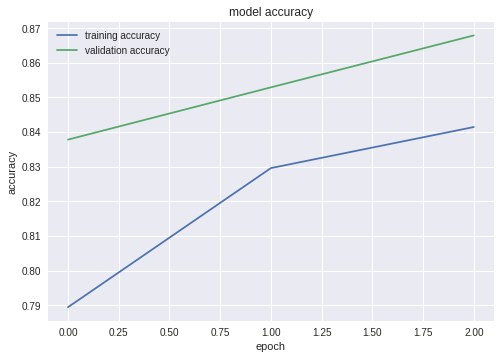

In [12]:
# 正解率
plt.plot(fit.history['acc'])
plt.plot(fit.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy', 'validation accuracy'], loc='upper left')
plt.show()

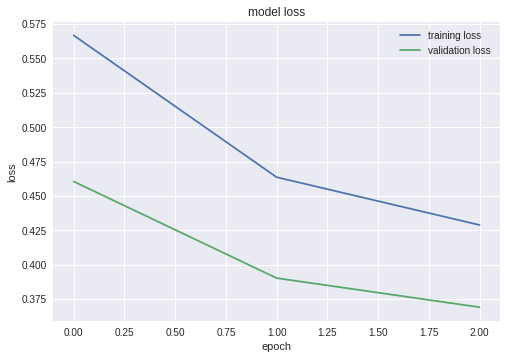

In [13]:
# 損失
plt.plot(fit.history['loss'])
plt.plot(fit.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss', 'validation loss'], loc='upper right')
plt.show()


## テスト
　学習させたモデルを使用して、分類性能をテストします。

### モデルの読み込みとテスト
　モデルを読み込み、テストデータを用いてテストをします。

In [14]:
model.load_weights('model.weights.best.hdf5')
score = model.evaluate(x_test, y_test, verbose=1)

10000/10000 [==============================] - 1s 149us/sample - loss: 0.3884 - acc: 0.8593


### 正解率と損失の出力
　テストの結果である正解率と損失を出力します。

In [15]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.3884081918954849
Test accuracy: 0.8593


### 混同行列の出力

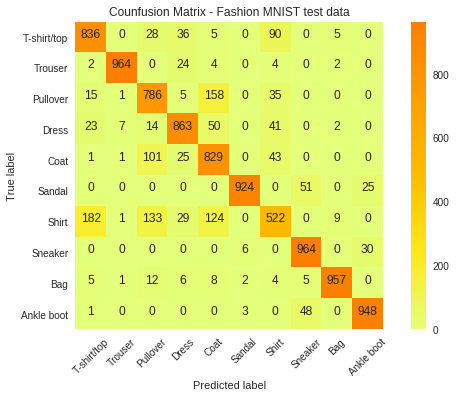

In [16]:
y_test_pred = model.predict(x_test)
y_true  = np.argmax(y_test, axis = 1)
y_pred = np.argmax(y_test_pred, axis = 1)
y_label = 'True label'
x_label = 'Predicted label'
title = 'Counfusion Matrix - Fashion MNIST test data'
save_path = 'confusin_matrix.png'
cm = confusion_matrix(y_true, y_pred)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(CLASS_NAMES))
plt.xticks(tick_marks, CLASS_NAMES, rotation=45)
plt.yticks(tick_marks, CLASS_NAMES)
for i in range(len(CLASS_NAMES)):
  for j in range(len(CLASS_NAMES)):
    plt.text(j,i, str(cm[i][j]), horizontalalignment="center")
plt.tight_layout()
plt.ylabel(y_label)
plt.xlabel(x_label)
ax = plt.gca() # get current axis
ax.grid(False) 
plt.savefig(save_path)

### テスト結果の視覚化
　テストデータの中からランダムで50枚取得し、その分類結果を表示します。キャプションが赤文字となっている画像はご分類した画像です。

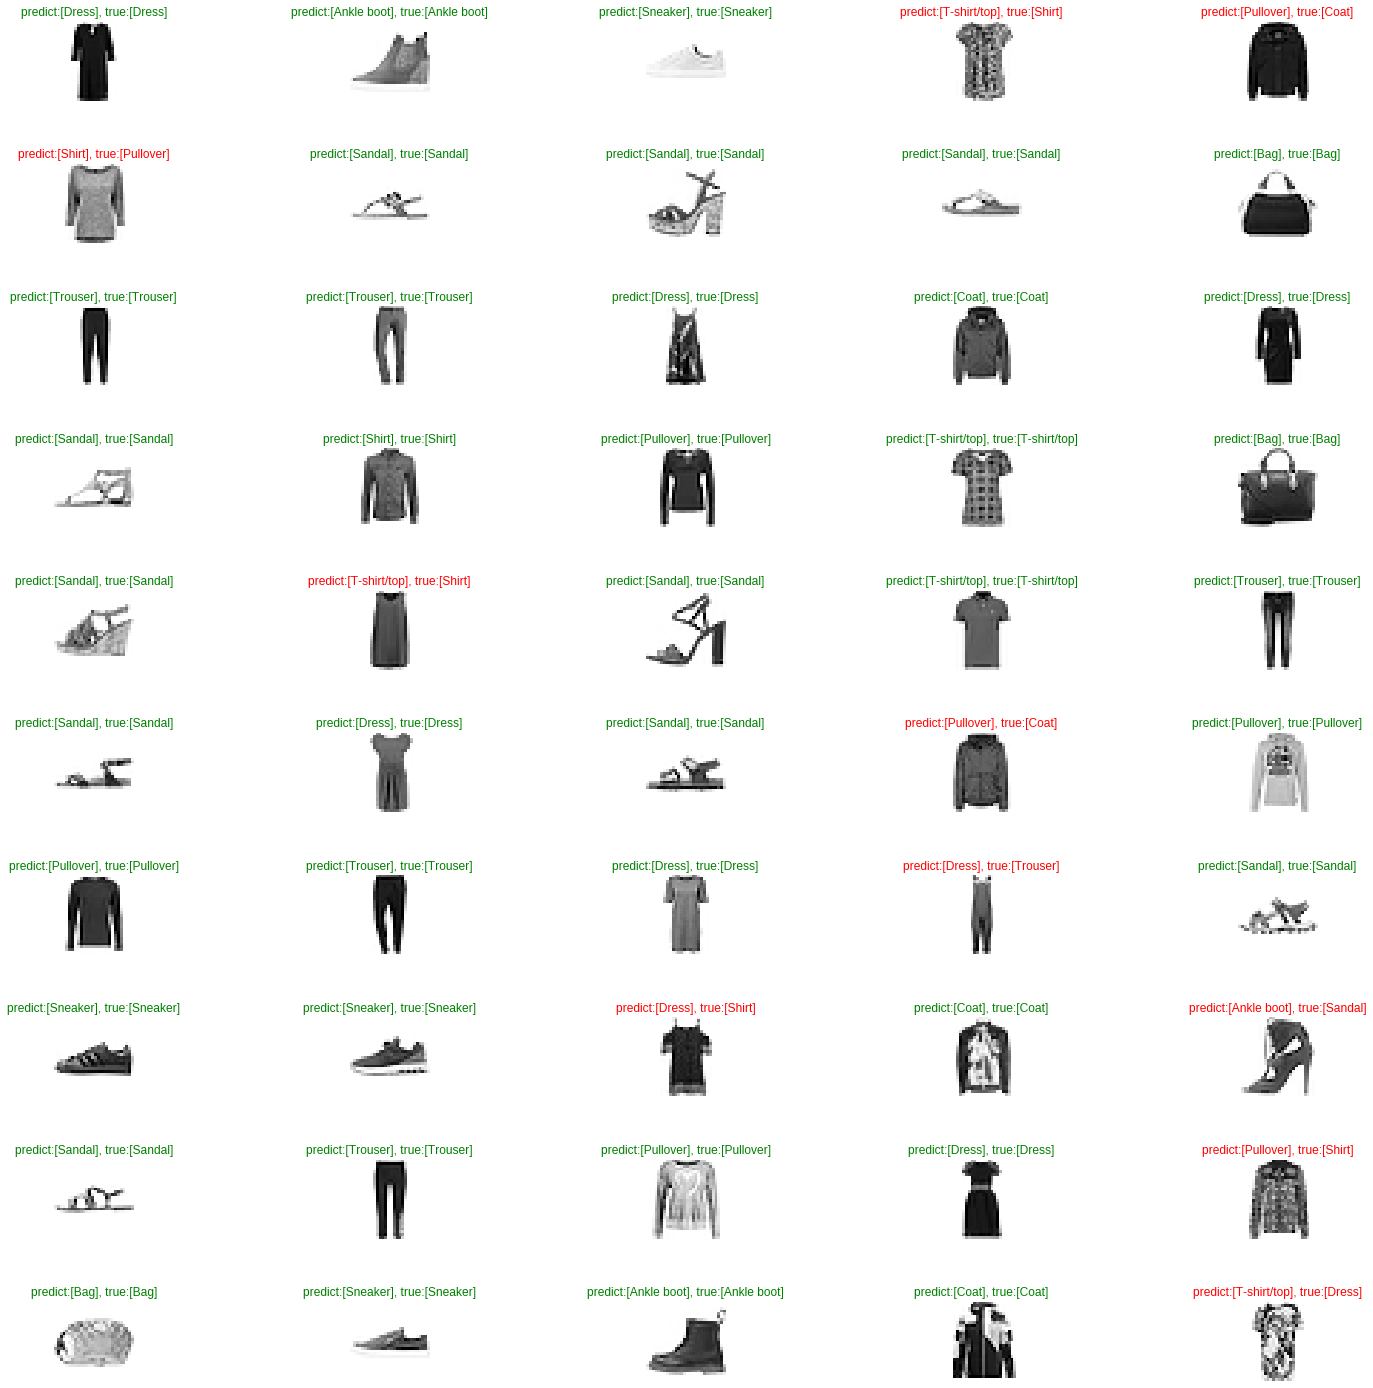

In [17]:
w_num = 5
h_num = 10
figure = plt.figure(figsize=(25, 25))
plt.subplots_adjust(wspace=0.4, hspace=0.8)
for i, index in enumerate(np.random.choice(x_test.shape[0], size=w_num * h_num, replace=False)):
  ax = figure.add_subplot(h_num, w_num, i + 1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(x_test[index]))
  pred_index = np.argmax(y_test_pred[index])
  true_index = np.argmax(y_test[index])
  ax.set_title("predict:[{}], true:[{}]".format(CLASS_NAMES[pred_index], CLASS_NAMES[true_index]), color=("green" if pred_index == true_index else "red"))
        